Counter({'c': 83996, 'b': 76703, 'd': 76032, 'a': 44341, 'e': 7353, 'g': 7126, 'f': 7015})


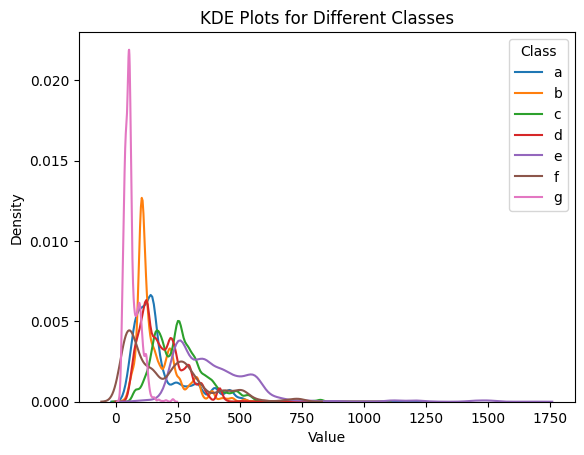

In [1]:
from Bio import SeqIO 
from collections import Counter

counter = Counter()
lengths = {}
for record in SeqIO.parse("tmp/astral.fasta", "fasta"):

    
    _class = record.description.split()[1][0]
    counter[_class] += 1

    if _class not in lengths:

        lengths[_class] = []

    lengths[_class].append(len(record.seq))
    

print(counter)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()

for class_ in lengths: 
    sns.kdeplot(lengths[class_], label=class_)

plt.title('KDE Plots for Different Classes')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Class')

plt.show()

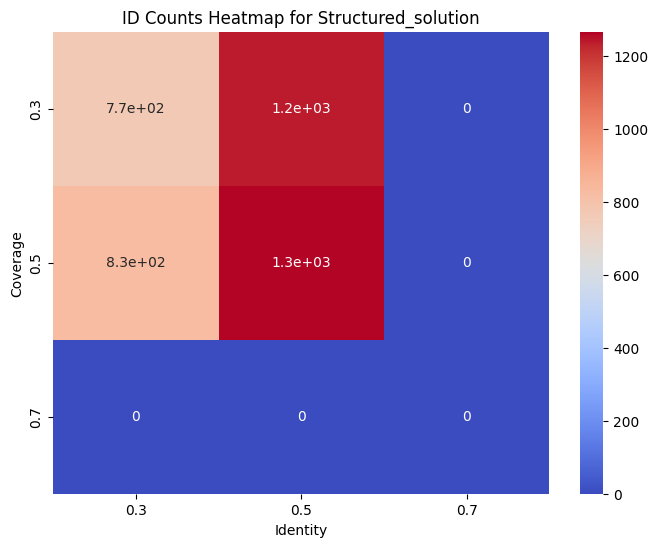

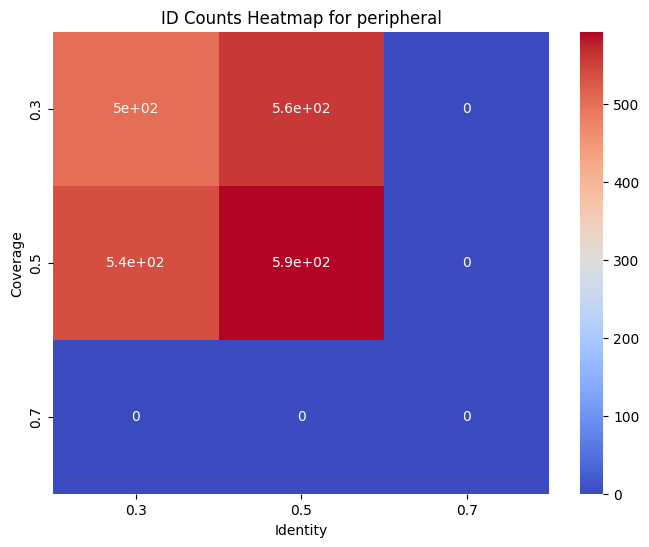

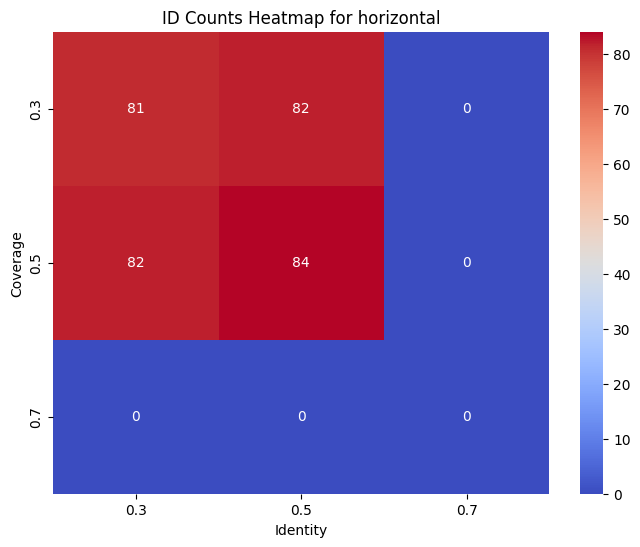

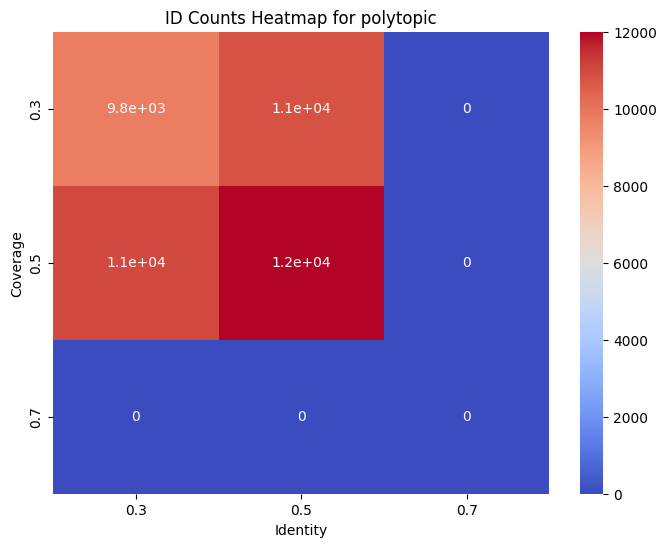

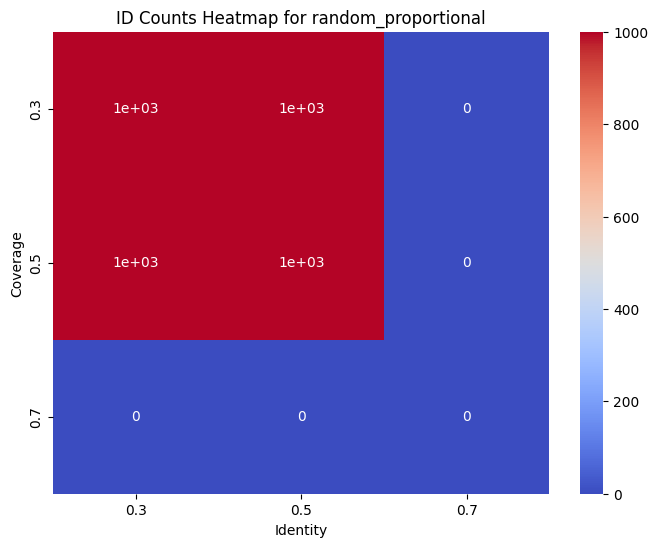

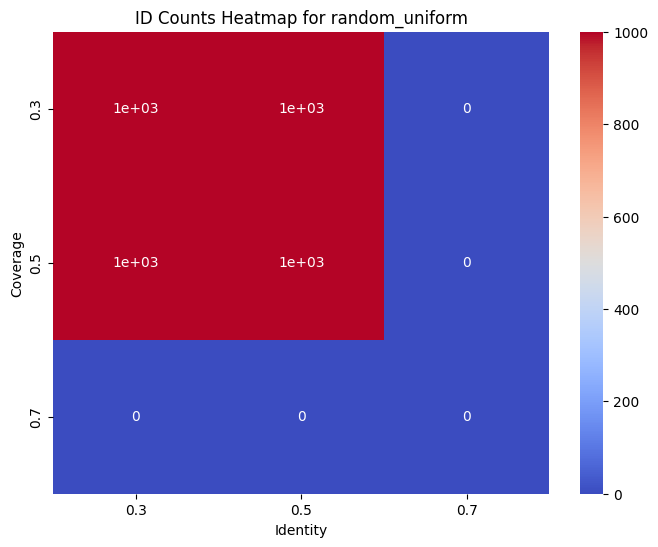

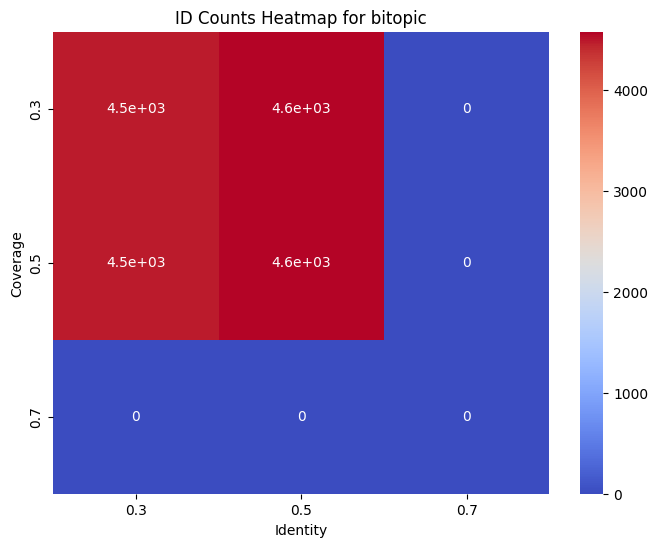

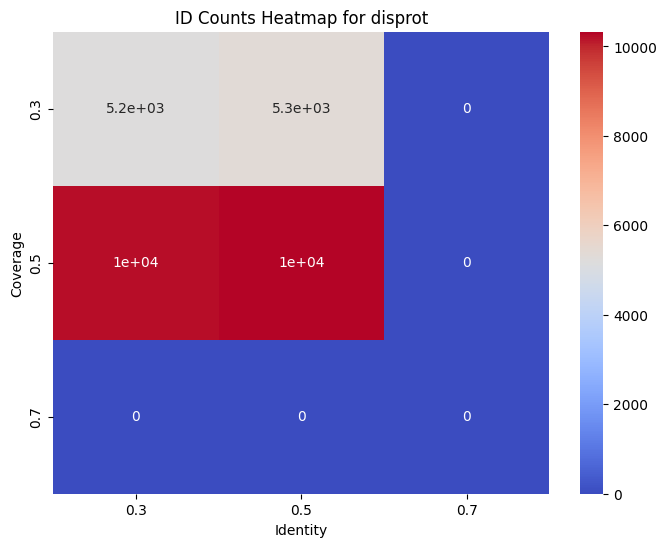

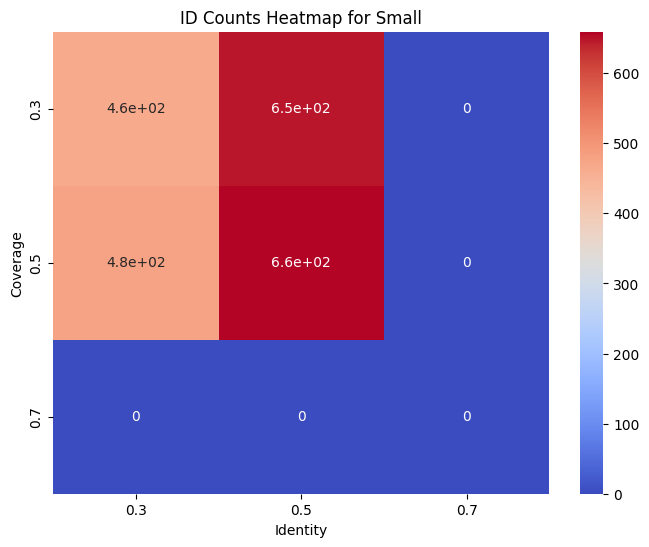

In [12]:
import os
import re
import matplotlib.pyplot as plt

# Function to extract information from the filename
def extract_info_from_filename(filename):
    pattern = r"([a-zA-Z_]+)_cov_(0\.\d)_iden_(0\.\d)\.txt"
    match = re.match(pattern, filename)
    if match:
        category = match.group(1)
        coverage = float(match.group(2))
        identity = float(match.group(3))
        return category, coverage, identity
    return None

# Function to count the number of IDs in a file
def count_ids_in_file(filepath):
    with open(filepath, 'r') as file:
        ids = file.readlines()
        return len(ids)

# Directory containing the files
directory = './database/representatives'  # Change to your directory if needed

# Dictionary to store data
data = {}

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        
        # Extract information from the filename
        info = extract_info_from_filename(filename)
        if info:
            category, coverage, identity = info
            
            # Count the number of IDs in the file
            id_count = count_ids_in_file(filepath)
            
            # Store the data in the dictionary
            if category not in data:
                data[category] = []
            data[category].append((coverage, identity, id_count))


import seaborn as sns
import numpy as np

for category, values in data.items():
    # Create a pivot table of coverage, identity, and ID counts
    heatmap_data = np.zeros((3, 3))  # Assuming there are 3 coverage and 3 identity values (0.3, 0.5, 0.7)
    for cov, iden, id_count in values:
        cov_index = int((cov - 0.3) / 0.2)  # Converts 0.3, 0.5, 0.7 to indices 0, 1, 2
        iden_index = int((iden - 0.3) / 0.2)
        heatmap_data[cov_index, iden_index] = id_count
    
    # Plot heatmap using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", xticklabels=[0.3, 0.5, 0.7], yticklabels=[0.3, 0.5, 0.7])
    plt.title(f"ID Counts Heatmap for {category}")
    plt.xlabel('Identity')
    plt.ylabel('Coverage')
    
    # Save the plot or show it
    plt.savefig(f"{category}_heatmap.png")
    # plt.show()
